In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
past = 'C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Previsoes/'

In [4]:
previsoes_np = {}
previsoes = []
for index in range(3):
    with open(past+f'Prev_pro/Previsao_pro{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])


In [5]:
previsoes_np['demandas'] = previsoes
previsoes_np = pd.DataFrame(previsoes_np)
previsoes_np.head()

,demandas
0,"[9877.404296875, 9904.2919921875, 9926.2109375..."
1,"[9904.1240234375, 9921.4599609375, 9949.382812..."
2,"[9865.751953125, 9890.9169921875, 9911.578125,..."


In [6]:
previsoes_sar = {}
previsoes = []
for index in range(3):
    with open(past+f'Prev_sar/Previsao_sar{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_sar['demandas'] = previsoes
previsoes_sar = pd.DataFrame(previsoes_sar)
previsoes_sar.head()

,demandas
0,"[9925.6957472608, 9920.938361816821, 9873.0590..."
1,"[9925.6957472608, 9920.938361816821, 9873.0590..."
2,"[9925.6957472608, 9920.938361816821, 9873.0590..."


In [7]:
def describe_var(dataframe,var):
    resultado_var = {}
    
    for periodo in range(len(dataframe.iloc[0,0])):
        aux = []
        for list in dataframe[var]:
            aux.append(list[periodo])
        resultado_var[f'{var}{periodo+1}'] = aux

    return pd.DataFrame(resultado_var)

In [8]:
def describe_var_grafico(describe1_var,describe2_var,var):
    fig=plt.figure(figsize=(6,3))

    plt.plot(range(len(describe1_var.columns)),describe1_var.iloc[1,:],color='blue',label='Floresta Aleatória')
    plt.plot(range(len(describe2_var.columns)),describe2_var.iloc[1,:],color='red',label='Rede Neural')

    plt.xlabel(var)
    plt.ylabel('Valor Médio')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def describe_var_desv_grafico(describe1_var,describe2_var,var):
    fig=plt.figure(figsize=(6,3))

    plt.plot(range(len(describe1_var.columns)),describe1_var.iloc[2,:],color='blue',label='Floresta Aleatória')
    plt.plot(range(len(describe2_var.columns)),describe2_var.iloc[2,:],color='red',label='Rede Neural')

    plt.xlabel(var)
    plt.ylabel('Desvio Padrão')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
vars1 = describe_var(previsoes_np,'demandas')
vars2 = describe_var(previsoes_sar,'demandas')

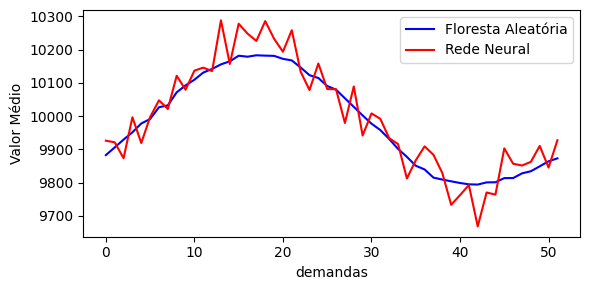

In [11]:
describe_var_grafico(vars1.describe(),vars2.describe(),'demandas')

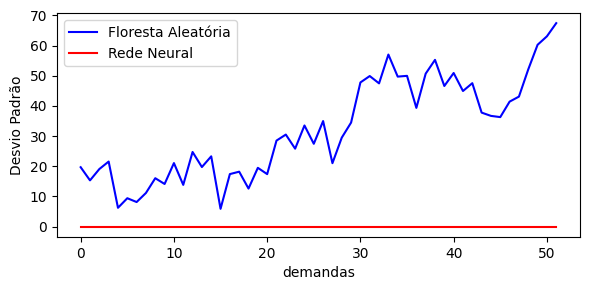

In [12]:
describe_var_desv_grafico(vars1.describe(),vars2.describe(),'demandas')

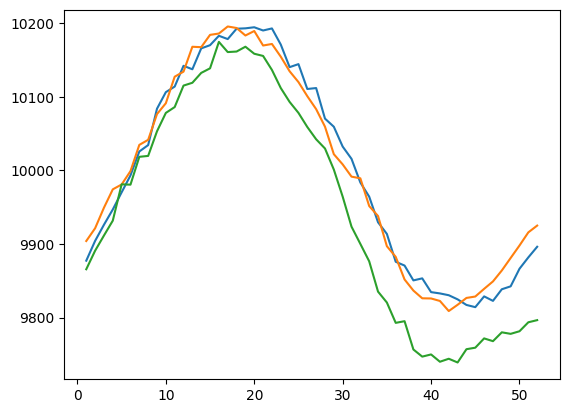

In [13]:
fig=plt.figure(figsize=(6,3))
for i in range(3):
    plt.plot(range(1,53),vars1.iloc[i,:])